# GSE172114 RNA-seq Analysis

## Analysis summary

Current pipeline uses:
- SRA Tools and entrez-direct - to get raw FASTQ files from NCBI >
- FastQC/MultiQC - for quality control >
- trimmomatic - for adapter trimming and excluding incomplete reads >
- STAR - for building index and alignment to GENCODE v23 reference >
- featureCounts - to quantify the reads >
- pyDESEQ2 - for Differential expression >
- pyGSEA - for Gene Set Enrichment Analysis >
- pyWGCNA - for Weighted Gene Network Correlation Analysis >
- seq2HLA - for HLA-II genes typing >
- Kassandra - for Deconvolution analysis 
(for deconvolution analysis transcript abundances were calculated using Kallisto with a custom Toil/Xena project index file)

All the tools were chosen based on their high popularity and cited peer reviewed publications, giving the preference to python tools.

The pipeline was mostly run on a SLURM HPC via interactive shell to make it more transferrable to non-HPC machines.
(SLURM instructions may be found in cluster_setup_listing.sh in root folder)

Snakemake workflow manager was used to facilitate the robustness of the pipeline.

FASTQ files were downloaded from SRA repository by using a custom script
    get_raw_data.sh

This script is located in snakemake/shellScripts folder and requires SRA-Tools (was loaded via SLURM module manager: module load SRA-Toolkit), entrez-direct and parallel (were installed into conda environment).

get_raw_data.sh prompts user to enter GSE accession. After that the script converts GSE to SRR accessions, downloads SRA files, converts them to FASTQ and moves to an appropriate directory for further analysis.

Once the raw data are downloaded, the rest of the pipeline can be launched from snakemake folder by using
    snakemake -j <jobs> -c <cores> command

The pipeline was run on a 192 CPU 512GB partition of the HPC.

Quality control or raw data and other steps (with MultiQC) indicated reasonable data quality. The html reports can be found in corresponding folders depending on the tool.

The downstream analysis (in the 'downstream_analysis' directory) was mainly performed on a Jupyter Lab instance of the HPC with 8 CPU and 128GB memory.

Analysis was performed using conda or virtualenv environment. Specifications of the environment are in spec-file.txt in the 'downstream_analysis' directory.

## Dataset Configuration

In [4]:
import pickle as pkl

# True to import results of DESeq2 statistical analysis from pickle object

IMPORT_PICKLES = False
CREATE_METAFILE = False

In [5]:
# Some useful objects like statistical analysis results are saved to pickle objects
# and can be loaded without re-execution

if IMPORT_PICKLES:
    deseq2_stats_file = open('deseq2_output/shrunk_stat_results_detailed_pipe.pkl', 'rb')
    stat_res = pkl.load(deseq2_stats_file)
    deseq2_stats_file.close()

In [6]:
# stat_res.results_df.shape

In [7]:
# Counfigure featureCounts output directory, GSE accession and genome assembly for annotation and metadata
FEATURE_COUNTS_DIR = "snakemake/featureCounts"
SEQ2HLA_DIR = "snakemake/hla_typing"
GSE_ACCESSION = 'GSE172114'
SPECIES = 'human'
GENCODE_RELEASE = 29
DOWNLOAD_ANNOTATION = False
# Save LFC into object
SAVE = True

# LFC output path
OUTPUT_PATH_DESEQ2 = "deseq2_output/"
OUTPUT_PATH_WGCNA = "wgcna_output/"
OUTPUT_PATH_SEQ2HLA= "seq2hla_output/"

WORKING_DIR = "/wrk-vakka/users/nikiarte/rnaseq_analysis"

In [8]:
!cd {WORKING_DIR}

## Loading libraries and annotation

In [302]:
import os
import glob
import pandas as pd
import seaborn as sns
from functools import reduce
import numpy as np
import PyWGCNA

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

import matplotlib.pyplot as plt

from IPython.display import Image
from core.mixer import Mixer
from core.cell_types import CellTypes
from core.model import DeconvolutionModel
from core.plotting import print_cell_matras, cells_p, print_all_cells_in_one
from core.utils import *

In [10]:
if DOWNLOAD_ANNOTATION:
    !wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_{SPECIES}/release_{GENCODE_RELEASE}/gencode.v{GENCODE_RELEASE}.annotation.gtf.gz
    !gunzip gencode.v29.annotation.gtf.gz

In [11]:
# Create output path for analysis if want to save results
if SAVE:
    OUTPUT_PATH = "deseq2_output/"
    os.makedirs(OUTPUT_PATH, exist_ok=True)

## Functions

In [12]:
# At first I actually moved the counts files from featureCounts directory to downstream_analysis/data/counts and worked with them there. I now think it was a better idea

In [13]:
def import_featureCounts(featureCounts_dir):
    # A function to read featureCounts output files and convert them into a data frame
    # Remove the program call from the first lines
    counts_list = []
    counts_path = os.path.join(WORKING_DIR, featureCounts_dir, "*.txt")
    #count_file_list = glob.glob(featureCounts_dir + "/*.txt")
    count_file_list = glob.glob(counts_path)
    print(counts_path)
    print(featureCounts_dir + "/*.txt")
    print(count_file_list)
    for count_file in count_file_list:
#       with open(count_file, "r+") as file:
#           lines = file.readlines()
#           print("Length " + str(len(lines)))
#            if not ("Geneid" in lines[0]):
#                print("Removing first line...")
#                del lines[0]
#                print(len(lines))
#                file.seek(0)
#                for i in lines:
#                    file.write(i)
#                file.truncate()
        raw_df = pd.read_csv(count_file, sep="\t", comment='#')
        accession = count_file.split("/")[-1][:-4]
        print("Reading " + accession)
        
        counts_list.append(pd.DataFrame(
            {'gene_id': raw_df.Geneid,
             accession: raw_df["mapped/" + accession + "Aligned.sortedByCoord.out.bam"]}
        )
                        )
    counts_df = reduce(lambda df1, df2: pd.merge(df1, df2, on="gene_id", how="left"), counts_list)
    print("----")
    print("Read " + str(len(count_file_list)) + " featureCounts files")
    return counts_df
    
# test_df = pd.read_csv("data/counts/SRR14240731.txt", sep="\t")

In [14]:
def gene_info(x):
    # A function to parse genome annotation file attribute field
    gene_name = x.split("gene_name ")[1].split(";")[0][1:-1]
    gene_ensg = x.split("gene_id ")[1].split(";")[0][1:-1]
    gene_type = x.split("gene_type ")[1].split(";")[0][1:-1]
    return (gene_name, gene_ensg, gene_type)

In [15]:
def rm_versions(x):
    # A function to remove Ensembl gene id versions
    x = x.split(".")[0]
    return x

In [16]:
def import_seq2hla(seq2hla_out_dir):
    # A function to load HLA-II typing results to a dataframe
    hla_files_path = os.path.join(WORKING_DIR, seq2hla_out_dir)
    hla_files_2digits = glob.glob(hla_files_path + "/*ClassII.HLAgenotype2digits")
    hla_files_4digits = glob.glob(hla_files_path + "/*ClassII.HLAgenotype4digits")
    df_list = []
    for short_geno, long_geno in zip(hla_files_2digits, hla_files_4digits):
        path_short_geno = os.path.join(hla_files_path, short_geno)
        path_long_geno = os.path.join(hla_files_path, long_geno)
        accession = short_geno.split("/")[7].split("-")[0]
        df_short = pd.read_csv(path_short_geno, sep="\t")
        df_short["precision"] = ["2digits" for i in range(0, len(df_short.index))]
        df_short["accession"] = [accession for i in range(0, len(df_short.index))]
        df_long = pd.read_csv(path_long_geno, sep="\t")
        df_long["precision"] = ["4digits" for i in range(0, len(df_short.index))]
        df_long["accession"] = [accession for i in range(0, len(df_short.index))]
        accession_df = pd.concat([df_short, df_long])
        df_list.append(accession_df)
    full_hla_df = pd.concat(df_list, ignore_index=True)
    full_hla_df.rename({"#Locus": "Locus"}, axis='columns', inplace=True)
    return full_hla_df 

In [17]:
def import_kallisto(kallisto_out_dir):
    # A function to load Kallisto pseudoalignment results to a dataframe for deconvolution analysis
    accession_dirs_path = os.path.join(WORKING_DIR, kallisto_out_dir)
    accession_dirs = glob.glob(accession_dirs_path + "/SRR*")
    counts_list = []
    for accession in accession_dirs:
        abundance_path = os.path.join(WORKING_DIR, kallisto_out_dir, accession, "abundance.tsv")
        accession_code = accession.split("kallisto_abundance")[1][1:]
        print(f'Reading {accession_code}')
        abundance = pd.read_csv(abundance_path, sep='\t', index_col=0)
        counts = pd.DataFrame(abundance["tpm"])
        counts.rename({"tpm": accession_code}, axis='columns', inplace=True)
        counts_list.append(counts)
    full_counts_df = pd.concat(counts_list, axis='columns')
    print("-------")
    print(f'Read {len(counts_list)} files')
    return full_counts_df

In [367]:
def split_hla_output(string):
    # Transform seq2HLA haplotypes into shorter form
    if "hoz" in string:
        return string.split('*')[1][:-2]
    else:
        return string.split('*')[1]

def prepare_hla_data_for_stats(hla_2digits, ):
    # Transform HLA table for statistical analysis
    loci_list = list(hla_2digits.Locus.unique())
    accession_list = list(hla_2digits.index.unique())
    allele_df_list = []
    for accession in accession_list:
        allele_df = hla_2digits[hla_2digits.index == accession]
        disease_state = allele_df.disease_state[0]
        allele_code_df = allele_df["Allele 1"].apply(
            lambda x: split_hla_output(x)
        ) + '_' + allele_df["Allele 2"].apply(
            lambda x: split_hla_output(x)
            )
        allele_code_df = pd.DataFrame(allele_code_df).T
        allele_code_df.columns = loci_list
        allele_code_df["disease_state"] = disease_state
        allele_code_df.index = [accession]
        allele_df_list.append(allele_code_df)
    full_allele_code_df = pd.concat(allele_df_list)
    return full_allele_code_df


def plot_hla_geno(LOCUS, GENOTYPE, hla_stats_df):
    hla_stats_df[hla_stats_df[LOCUS] == GENOTYPE].groupby('disease_state').count().iloc[:,0].plot.bar(title=f'{LOCUS}: {GENOTYPE}')

## Read featureCounts data

In [18]:
# Also make sure the tables are of the same length
counts_df_full = import_featureCounts(FEATURE_COUNTS_DIR)

/wrk-vakka/users/nikiarte/rnaseq_analysis/snakemake/featureCounts/*.txt
snakemake/featureCounts/*.txt
['/wrk-vakka/users/nikiarte/rnaseq_analysis/snakemake/featureCounts/SRR14240791.txt', '/wrk-vakka/users/nikiarte/rnaseq_analysis/snakemake/featureCounts/SRR14240740.txt', '/wrk-vakka/users/nikiarte/rnaseq_analysis/snakemake/featureCounts/SRR14240796.txt', '/wrk-vakka/users/nikiarte/rnaseq_analysis/snakemake/featureCounts/SRR14240747.txt', '/wrk-vakka/users/nikiarte/rnaseq_analysis/snakemake/featureCounts/SRR14240735.txt', '/wrk-vakka/users/nikiarte/rnaseq_analysis/snakemake/featureCounts/SRR14240798.txt', '/wrk-vakka/users/nikiarte/rnaseq_analysis/snakemake/featureCounts/SRR14240749.txt', '/wrk-vakka/users/nikiarte/rnaseq_analysis/snakemake/featureCounts/SRR14240732.txt', '/wrk-vakka/users/nikiarte/rnaseq_analysis/snakemake/featureCounts/SRR14240772.txt', '/wrk-vakka/users/nikiarte/rnaseq_analysis/snakemake/featureCounts/SRR14240775.txt', '/wrk-vakka/users/nikiarte/rnaseq_analysis/snak

## Read annotation

In [19]:
annotation = pd.read_table("gencode.v29.annotation.gtf", comment="#",
                        sep = "\t", names = ['seqname', 'source', 'feature', 'start' , 'end', 'score', 'strand', 'frame', 'attribute'])
annotation_genes = annotation[(
    annotation.feature == "gene")][['seqname', 'start', 'end', 'attribute']].copy().reset_index().drop('index', axis=1)



In [20]:
annotation_genes

seqname  start    end                                          attribute
0        chr1  11869  14409  gene_id "ENSG00000223972.5"; gene_type "transc...
1        chr1  14404  29570  gene_id "ENSG00000227232.5"; gene_type "unproc...
2        chr1  17369  17436  gene_id "ENSG00000278267.1"; gene_type "miRNA"...
3        chr1  29554  31109  gene_id "ENSG00000243485.5"; gene_type "lincRN...
4        chr1  30366  30503  gene_id "ENSG00000284332.1"; gene_type "miRNA"...
...       ...    ...    ...                                                ...
58716    chrM  14149  14673  gene_id "ENSG00000198695.2"; gene_type "protei...
58717    chrM  14674  14742  gene_id "ENSG00000210194.1"; gene_type "Mt_tRN...
58718    chrM  14747  15887  gene_id "ENSG00000198727.2"; gene_type "protei...
58719    chrM  15888  15953  gene_id "ENSG00000210195.2"; gene_type "Mt_tRN...
58720    chrM  15956  16023  gene_id "ENSG00000210196.2"; gene_type "Mt_tRN...

[58721 rows x 4 columns]

In [21]:
# Parsing the 'attribute' field in the annotation file
annotation_genes["gene_name"], annotation_genes["gene_id"], annotation_genes["gene_type"] = zip(*annotation_genes.attribute.apply(lambda x: gene_info(x)))
annotation_genes

seqname  start    end  \
0        chr1  11869  14409   
1        chr1  14404  29570   
2        chr1  17369  17436   
3        chr1  29554  31109   
4        chr1  30366  30503   
...       ...    ...    ...   
58716    chrM  14149  14673   
58717    chrM  14674  14742   
58718    chrM  14747  15887   
58719    chrM  15888  15953   
58720    chrM  15956  16023   

                                               attribute    gene_name  \
0      gene_id "ENSG00000223972.5"; gene_type "transc...      DDX11L1   
1      gene_id "ENSG00000227232.5"; gene_type "unproc...       WASH7P   
2      gene_id "ENSG00000278267.1"; gene_type "miRNA"...    MIR6859-1   
3      gene_id "ENSG00000243485.5"; gene_type "lincRN...  MIR1302-2HG   
4      gene_id "ENSG00000284332.1"; gene_type "miRNA"...    MIR1302-2   
...                                                  ...          ...   
58716  gene_id "ENSG00000198695.2"; gene_type "protei...       MT-ND6   
58717  gene_id "ENSG00000210194.1"; gene_type "Mt_tRN...        MT-TE   
58718  gene_id "ENSG00000198727.2"; gene_type "protei...       MT-CYB   
58719  gene_id "ENSG00000210195.2"; gene_type "Mt_tRN...        MT-TT   
58720  gene_id "ENSG00000210196.2"; gene_type "Mt_tRN...        MT-TP   

                 gene_id                           gene_type  
0      ENSG00000223972.5  transcribed_unprocessed_pseudogene  
1      ENSG00000227232.5              unprocessed_pseudogene  
2      ENSG00000278267.1                               miRNA  
3      ENSG00000243485.5                             lincRNA  
4      ENSG00000284332.1                               miRNA  
...                  ...                                 ...  
58716  ENSG00000198695.2                      protein_coding  
58717  ENSG00000210194.1                             Mt_tRNA  
58718  ENSG00000198727.2                      protein_coding  
58719  ENSG00000210195.2                             Mt_tRNA  
58720  ENSG00000210196.2                             Mt_tRNA  

[58721 rows x 7 columns]

In [22]:
# annotation_genes_name_id = annotation_genes[annotation_genes.gene_type == "protein_coding"]
annotation_genes_name_id = pd.DataFrame().assign(gene_id=annotation_genes["gene_id"],
                                                 gene_name=annotation_genes["gene_name"])

In [23]:
annotation_genes_name_id

gene_id    gene_name
0      ENSG00000223972.5      DDX11L1
1      ENSG00000227232.5       WASH7P
2      ENSG00000278267.1    MIR6859-1
3      ENSG00000243485.5  MIR1302-2HG
4      ENSG00000284332.1    MIR1302-2
...                  ...          ...
58716  ENSG00000198695.2       MT-ND6
58717  ENSG00000210194.1        MT-TE
58718  ENSG00000198727.2       MT-CYB
58719  ENSG00000210195.2        MT-TT
58720  ENSG00000210196.2        MT-TP

[58721 rows x 2 columns]

In [24]:
# Adding annotations to the counts table
counts_df = pd.merge(annotation_genes_name_id, counts_df_full, on="gene_id", how="left")

In [25]:
counts_df[counts_df.gene_name.duplicated()]

gene_id   gene_name  SRR14240791  SRR14240740  \
286           ENSG00000252254.1     RF00019            0            0   
293           ENSG00000222511.2     RF00019            6            2   
410           ENSG00000202461.1     RF00019            0            0   
744           ENSG00000201405.1     RF00019           22           14   
785           ENSG00000239106.1     RF00019            0            0   
...                         ...         ...          ...          ...   
58679  ENSG00000124334.17_PAR_Y        IL9R            0            0   
58680   ENSG00000270726.6_PAR_Y  AJ271736.1            0            0   
58681  ENSG00000185203.12_PAR_Y      WASIR1            0            0   
58682  ENSG00000182484.15_PAR_Y      WASH6P            0            0   
58683   ENSG00000227159.8_PAR_Y    DDX11L16            0            0   

       SRR14240796  SRR14240747  SRR14240735  SRR14240798  SRR14240749  \
286              0            0            0            0            0   
293              5            2           17            2            6   
410              0            1            0            0            0   
744             24           19           16           25           22   
785              0            0            0            0            0   
...            ...          ...          ...          ...          ...   
58679            0            0            0            0            0   
58680            0            0            0            0            0   
58681            0            0            0            0            0   
58682            0            0            0            0            0   
58683            0            0            0            0            0   

       SRR14240732  ...  SRR14240738  SRR14240795  SRR14240744  SRR14240792  \
286              0  ...            0            0            0            0   
293              6  ...           12            4            2            6   
410              0  ...            0            0            0            0   
744             38  ...           13           10           20           22   
785              0  ...            0            0            0            0   
...            ...  ...          ...          ...          ...          ...   
58679            0  ...            0            0            0            0   
58680            0  ...            0            0            0            0   
58681            0  ...            0            0            0            0   
58682            0  ...            0            0            0            0   
58683            0  ...            0            0            0            0   

       SRR14240743  SRR14240731  SRR14240736  SRR14240778  SRR14240776  \
286              0            2            0            0            0   
293              5            1            6            2            7   
410              0            0            0            0            0   
744              2           26           23           20           11   
785              0            0            0            0            0   
...            ...          ...          ...          ...          ...   
58679            0            0            0            0            0   
58680            0            0            0            0            0   
58681            0            0            0            0            0   
58682            0            0            0            0            0   
58683            0            0            0            0            0   

       SRR14240771  
286              0  
293             10  
410              0  
744             12  
785              0  
...            ...  
58679            0  
58680            0  
58681            0  
58682            0  
58683            0  

[1588 rows x 71 columns]

### Prepare counts matrix for DESeq2

In [26]:
counts_df = counts_df_full

counts_df = counts_df.T
header_row = counts_df.iloc[0]
counts_df = counts_df[1:]
counts_df.columns = header_row
counts_df.sort_index(inplace=True)
# Chose threshold of 30 reads total among samples, because a lot of samples
keep = counts_df.columns[counts_df.sum(axis=0) >= 30]
counts_df = counts_df[keep]

In [27]:
counts_df.head()

gene_id     ENSG00000223972.5 ENSG00000227232.5 ENSG00000278267.1  \
SRR14240730                 0                29                25   
SRR14240731                 8               136                33   
SRR14240732                 0                66                35   
SRR14240733                 2                33                 6   
SRR14240734                 2                37                20   

gene_id     ENSG00000238009.6 ENSG00000239945.1 ENSG00000233750.3  \
SRR14240730                40                 4                 4   
SRR14240731                39                 4                 5   
SRR14240732                13                 0                 0   
SRR14240733                36                 0                 4   
SRR14240734               205                 3                 2   

gene_id     ENSG00000268903.1 ENSG00000269981.1 ENSG00000239906.1  \
SRR14240730                19                 3                 9   
SRR14240731                30                 3                 2   
SRR14240732                16                 0                 4   
SRR14240733                48                 2                12   
SRR14240734                79                 2                25   

gene_id     ENSG00000241860.6  ... ENSG00000198886.2 ENSG00000210176.1  \
SRR14240730                65  ...               659                36   
SRR14240731                96  ...              1424                11   
SRR14240732                42  ...               910                52   
SRR14240733               134  ...               772                 2   
SRR14240734               286  ...               358                12   

gene_id     ENSG00000210184.1 ENSG00000210191.1 ENSG00000198786.2  \
SRR14240730                36                 7               340   
SRR14240731                12                17               480   
SRR14240732                56                10               212   
SRR14240733                 2                 7               272   
SRR14240734                14                 4               166   

gene_id     ENSG00000198695.2 ENSG00000210194.1 ENSG00000198727.2  \
SRR14240730                32                 7               646   
SRR14240731               354               127              1446   
SRR14240732                36                18               554   
SRR14240733                10                 2               650   
SRR14240734                50                15               250   

gene_id     ENSG00000210195.2 ENSG00000210196.2  
SRR14240730                83                61  
SRR14240731                41                58  
SRR14240732               141               106  
SRR14240733                97               100  
SRR14240734                84                94  

[5 rows x 40588 columns]

## Creating metadata file

In [28]:
# Get the bioproject study accession to query metadata file from SRA to read metafile from NCBI
PYSRADB_PATH = "/wrk-vakka/users/nikiarte/rnaseq_analysis/deconvolution/kassandra-env/bin/pysradb gse-to-srp"
if CREATE_METAFILE:
    !{PYSRADB_PATH} {GSE_ACCESSION} > srp.txt
    srp = pd.read_csv("srp.txt", sep="\t")
    SRP_ACCESSION = srp.study_accession[0]
    print("Study accession is " + srp.study_accession[0])
    !rm srp.txt

In [29]:
if CREATE_METAFILE:
    # Query metadata table by project number
    !/wrk-vakka/users/nikiarte/rnaseq_analysis/deconvolution/kassandra-env/bin/pysradb gse-to-srp metadata {SRP_ACCESSION} --detailed > sample_metadata.txt

In [30]:
metadata_raw = pd.read_csv("sample_metadata.txt", sep="\t")

In [31]:
metadata = pd.DataFrame().assign(
    run_accession=metadata_raw["run_accession"],
    disease_state=metadata_raw["disease state"]
)

In [32]:
metadata.set_index('run_accession', inplace=True)
metadata.sort_index(inplace=True)
metadata

disease_state
run_accession              
SRR14240730    Non-critical
SRR14240731    Non-critical
SRR14240732    Non-critical
SRR14240733    Non-critical
SRR14240734    Non-critical
...                     ...
SRR14240794        Critical
SRR14240795        Critical
SRR14240796        Critical
SRR14240797        Critical
SRR14240798        Critical

[69 rows x 1 columns]

## pyDESeq2 Analysis

In [33]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="disease_state",
    refit_cooks=True,
    inference=inference,
)

In [34]:
import scanpy as sc

# Famous scRNA-seq tool, but also works easily with anndata objects and has a handy PCA function

In [35]:
sc.tl.pca(dds)

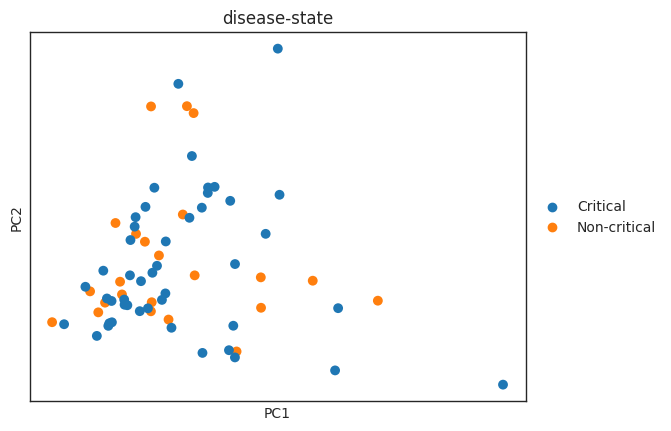

In [36]:
# PCA shows that samples do not really cluster by conditon
# We are not aware of batch effects, so will proceed
# In the original publication several omics datasets are used
# which may improve statistical power to differennnntiate between groups

sc.pl.pca(dds, color = 'disease-state', size = 200)

### Compute normalization factors

In [37]:
# Standard DeSEQ2 pipeline for single factor design

dds.fit_size_factors()

dds.obsm["size_factors"]

Fitting size factors...
... done in 0.42 seconds.



array([0.97885004, 1.58475074, 1.25865234, 0.95538811, 1.46642722,
       1.99529512, 1.42544942, 1.23654373, 1.52736254, 1.27424372,
       1.35482537, 1.32682361, 0.61756656, 0.68285452, 1.52225326,
       1.11358153, 1.41180852, 1.09889709, 1.19608667, 1.49847807,
       1.11699171, 1.02212802, 0.97141166, 1.21979302, 0.64762543,
       1.0393437 , 0.48061295, 0.85602963, 0.74829868, 0.56092712,
       1.35335225, 0.74657287, 1.44965289, 0.91380375, 1.07373772,
       1.38140585, 1.00501727, 0.98740889, 0.56582328, 1.24976368,
       1.18572123, 0.90608317, 0.77054981, 1.09808231, 0.33102054,
       1.39694373, 1.00058698, 0.74610031, 1.13295257, 1.22452738,
       1.44764246, 0.81132708, 0.82600742, 0.56236355, 1.36310522,
       0.54354166, 1.10046565, 1.14971395, 0.65418302, 0.78145935,
       0.85449492, 0.97968847, 0.75145644, 2.44813425, 0.46601431,
       0.8935974 , 1.04068207, 1.79057492, 0.9747499 ])

### Fit genewise dispersions

In [38]:
%%capture --no-display
dds.fit_genewise_dispersions()

dds.varm["genewise_dispersions"];

array([3.84794557, 0.16287869, 0.19012269, ..., 0.59872449, 0.93677759,
       0.39554558])

In [39]:
dds.fit_dispersion_trend()
dds.uns["trend_coeffs"]
dds.varm["fitted_dispersions"]

Fitting dispersion trend curve...
... done in 1.34 seconds.



array([2.90322807, 0.27716463, 0.44855578, ..., 0.1873075 , 0.23267123,
       0.26097705])

In [40]:
dds.fit_dispersion_prior()
print(
    f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}"
)

logres_prior=0.463265467423237, sigma_prior=0.4329647552483135


In [41]:
dds.fit_MAP_dispersions()
dds.varm["MAP_dispersions"]
dds.varm["dispersions"]

Fitting MAP dispersions...
... done in 23.20 seconds.



array([3.70337775, 0.16939018, 0.20772612, ..., 0.5626372 , 0.93677759,
       0.38577015])

In [42]:
dds.fit_LFC()
dds.varm["LFC"]

Fitting LFCs...
... done in 13.10 seconds.



intercept  disease-state_Non-critical_vs_Critical
gene_id                                                             
ENSG00000223972.5   0.659151                                0.529218
ENSG00000227232.5   4.244964                               -0.138108
ENSG00000278267.1   3.203972                               -0.070461
ENSG00000238009.6   5.138435                               -1.130711
ENSG00000239945.1   2.788489                               -1.646235
...                      ...                                     ...
ENSG00000198695.2   4.635584                               -0.570752
ENSG00000210194.1   3.665197                               -0.560093
ENSG00000198727.2   6.841759                               -0.457064
ENSG00000210195.2   4.980667                               -0.652355
ENSG00000210196.2   4.514082                               -0.468943

[40588 rows x 2 columns]

In [43]:
dds.calculate_cooks()
if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()

Calculating cook's distance...
... done in 0.46 seconds.

Replacing 473 outlier genes.

Fitting dispersions...
... done in 0.45 seconds.

Fitting MAP dispersions...
... done in 0.33 seconds.

Fitting LFCs...
... done in 0.24 seconds.



In [44]:
if SAVE:
    with open(os.path.join(OUTPUT_PATH_DESEQ2, "dds_detailed_pipe.pkl"), "wb") as f:
        pkl.dump(dds, f)

### Statistical analysis

In [45]:
stat_res = DeseqStats(dds, alpha=0.05, cooks_filter=True, independent_filter=True)

In [46]:
stat_res.run_wald_test()
stat_res.p_values

Running Wald tests...
... done in 42.35 seconds.



gene_id
ENSG00000223972.5    3.045290e-01
ENSG00000227232.5    2.077078e-01
ENSG00000278267.1    5.793250e-01
ENSG00000238009.6    6.830500e-10
ENSG00000239945.1    3.364430e-05
                         ...     
ENSG00000198695.2    8.932406e-03
ENSG00000210194.1    2.201071e-02
ENSG00000198727.2    1.716596e-02
ENSG00000210195.2    8.664927e-03
ENSG00000210196.2    3.691344e-03
Length: 40588, dtype: float64

In [47]:
if stat_res.cooks_filter:
    stat_res._cooks_filtering()
stat_res.p_values

gene_id
ENSG00000223972.5    3.045290e-01
ENSG00000227232.5    2.077078e-01
ENSG00000278267.1    5.793250e-01
ENSG00000238009.6    6.830500e-10
ENSG00000239945.1    3.364430e-05
                         ...     
ENSG00000198695.2    8.932406e-03
ENSG00000210194.1    2.201071e-02
ENSG00000198727.2    1.716596e-02
ENSG00000210195.2    8.664927e-03
ENSG00000210196.2    3.691344e-03
Length: 40588, dtype: float64

In [48]:
if stat_res.independent_filter:
    stat_res._independent_filtering()
else:
    stat_res._p_value_adjustment()

stat_res.padj

gene_id
ENSG00000223972.5    4.426230e-01
ENSG00000227232.5    3.347449e-01
ENSG00000278267.1    6.979957e-01
ENSG00000238009.6    2.944495e-08
ENSG00000239945.1    2.682934e-04
                         ...     
ENSG00000198695.2    2.907094e-02
ENSG00000210194.1    6.004905e-02
ENSG00000198727.2    4.930239e-02
ENSG00000210195.2    2.835987e-02
ENSG00000210196.2    1.406511e-02
Name: 10, Length: 40588, dtype: float64

In [49]:
stat_res.summary()

Log2 fold change & Wald test p-value: disease-state Non-critical vs Critical
                     baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                             
ENSG00000223972.5    2.396442        0.763501  0.743595  1.026769   
ENSG00000227232.5   66.742697       -0.199247  0.158146 -1.259894   
ENSG00000278267.1   24.248684       -0.101653  0.183367 -0.554371   
ENSG00000238009.6  131.982353       -1.631271  0.264389 -6.169965   
ENSG00000239945.1   11.902295       -2.375015  0.572668 -4.147284   
...                       ...             ...       ...       ...   
ENSG00000198695.2   88.155395       -0.823421  0.314928 -2.614630   
ENSG00000210194.1   33.513697       -0.808043  0.352829 -2.290183   
ENSG00000198727.2  821.586433       -0.659404  0.276696 -2.383134   
ENSG00000210195.2  122.448462       -0.941150  0.358534 -2.624999   
ENSG00000210196.2   79.980552       -0.676542  0.233017 -2.903400   

                         

In [50]:
if SAVE:
    with open(os.path.join(OUTPUT_PATH_DESEQ2, "stat_results_detailed_pipe.pkl"), "wb") as f:
        pkl.dump(stat_res, f)

Running Wald tests...
... done in 11.72 seconds.



Log2 fold change & Wald test p-value: disease-state Non-critical vs Critical
                     baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                             
ENSG00000223972.5    2.396442        0.763501  0.743595  0.892288   
ENSG00000227232.5   66.742697       -0.199247  0.158146 -0.627567   
ENSG00000278267.1   24.248684       -0.101653  0.183367 -0.009016   
ENSG00000238009.6  131.982353       -1.631271  0.264389 -5.791735   
ENSG00000239945.1   11.902295       -2.375015  0.572668 -3.972662   
...                       ...             ...       ...       ...   
ENSG00000198695.2   88.155395       -0.823421  0.314928 -2.297098   
ENSG00000210194.1   33.513697       -0.808043  0.352829 -2.006760   
ENSG00000198727.2  821.586433       -0.659404  0.276696 -2.021726   
ENSG00000210195.2  122.448462       -0.941150  0.358534 -2.346085   
ENSG00000210196.2   79.980552       -0.676542  0.233017 -2.474248   

                         

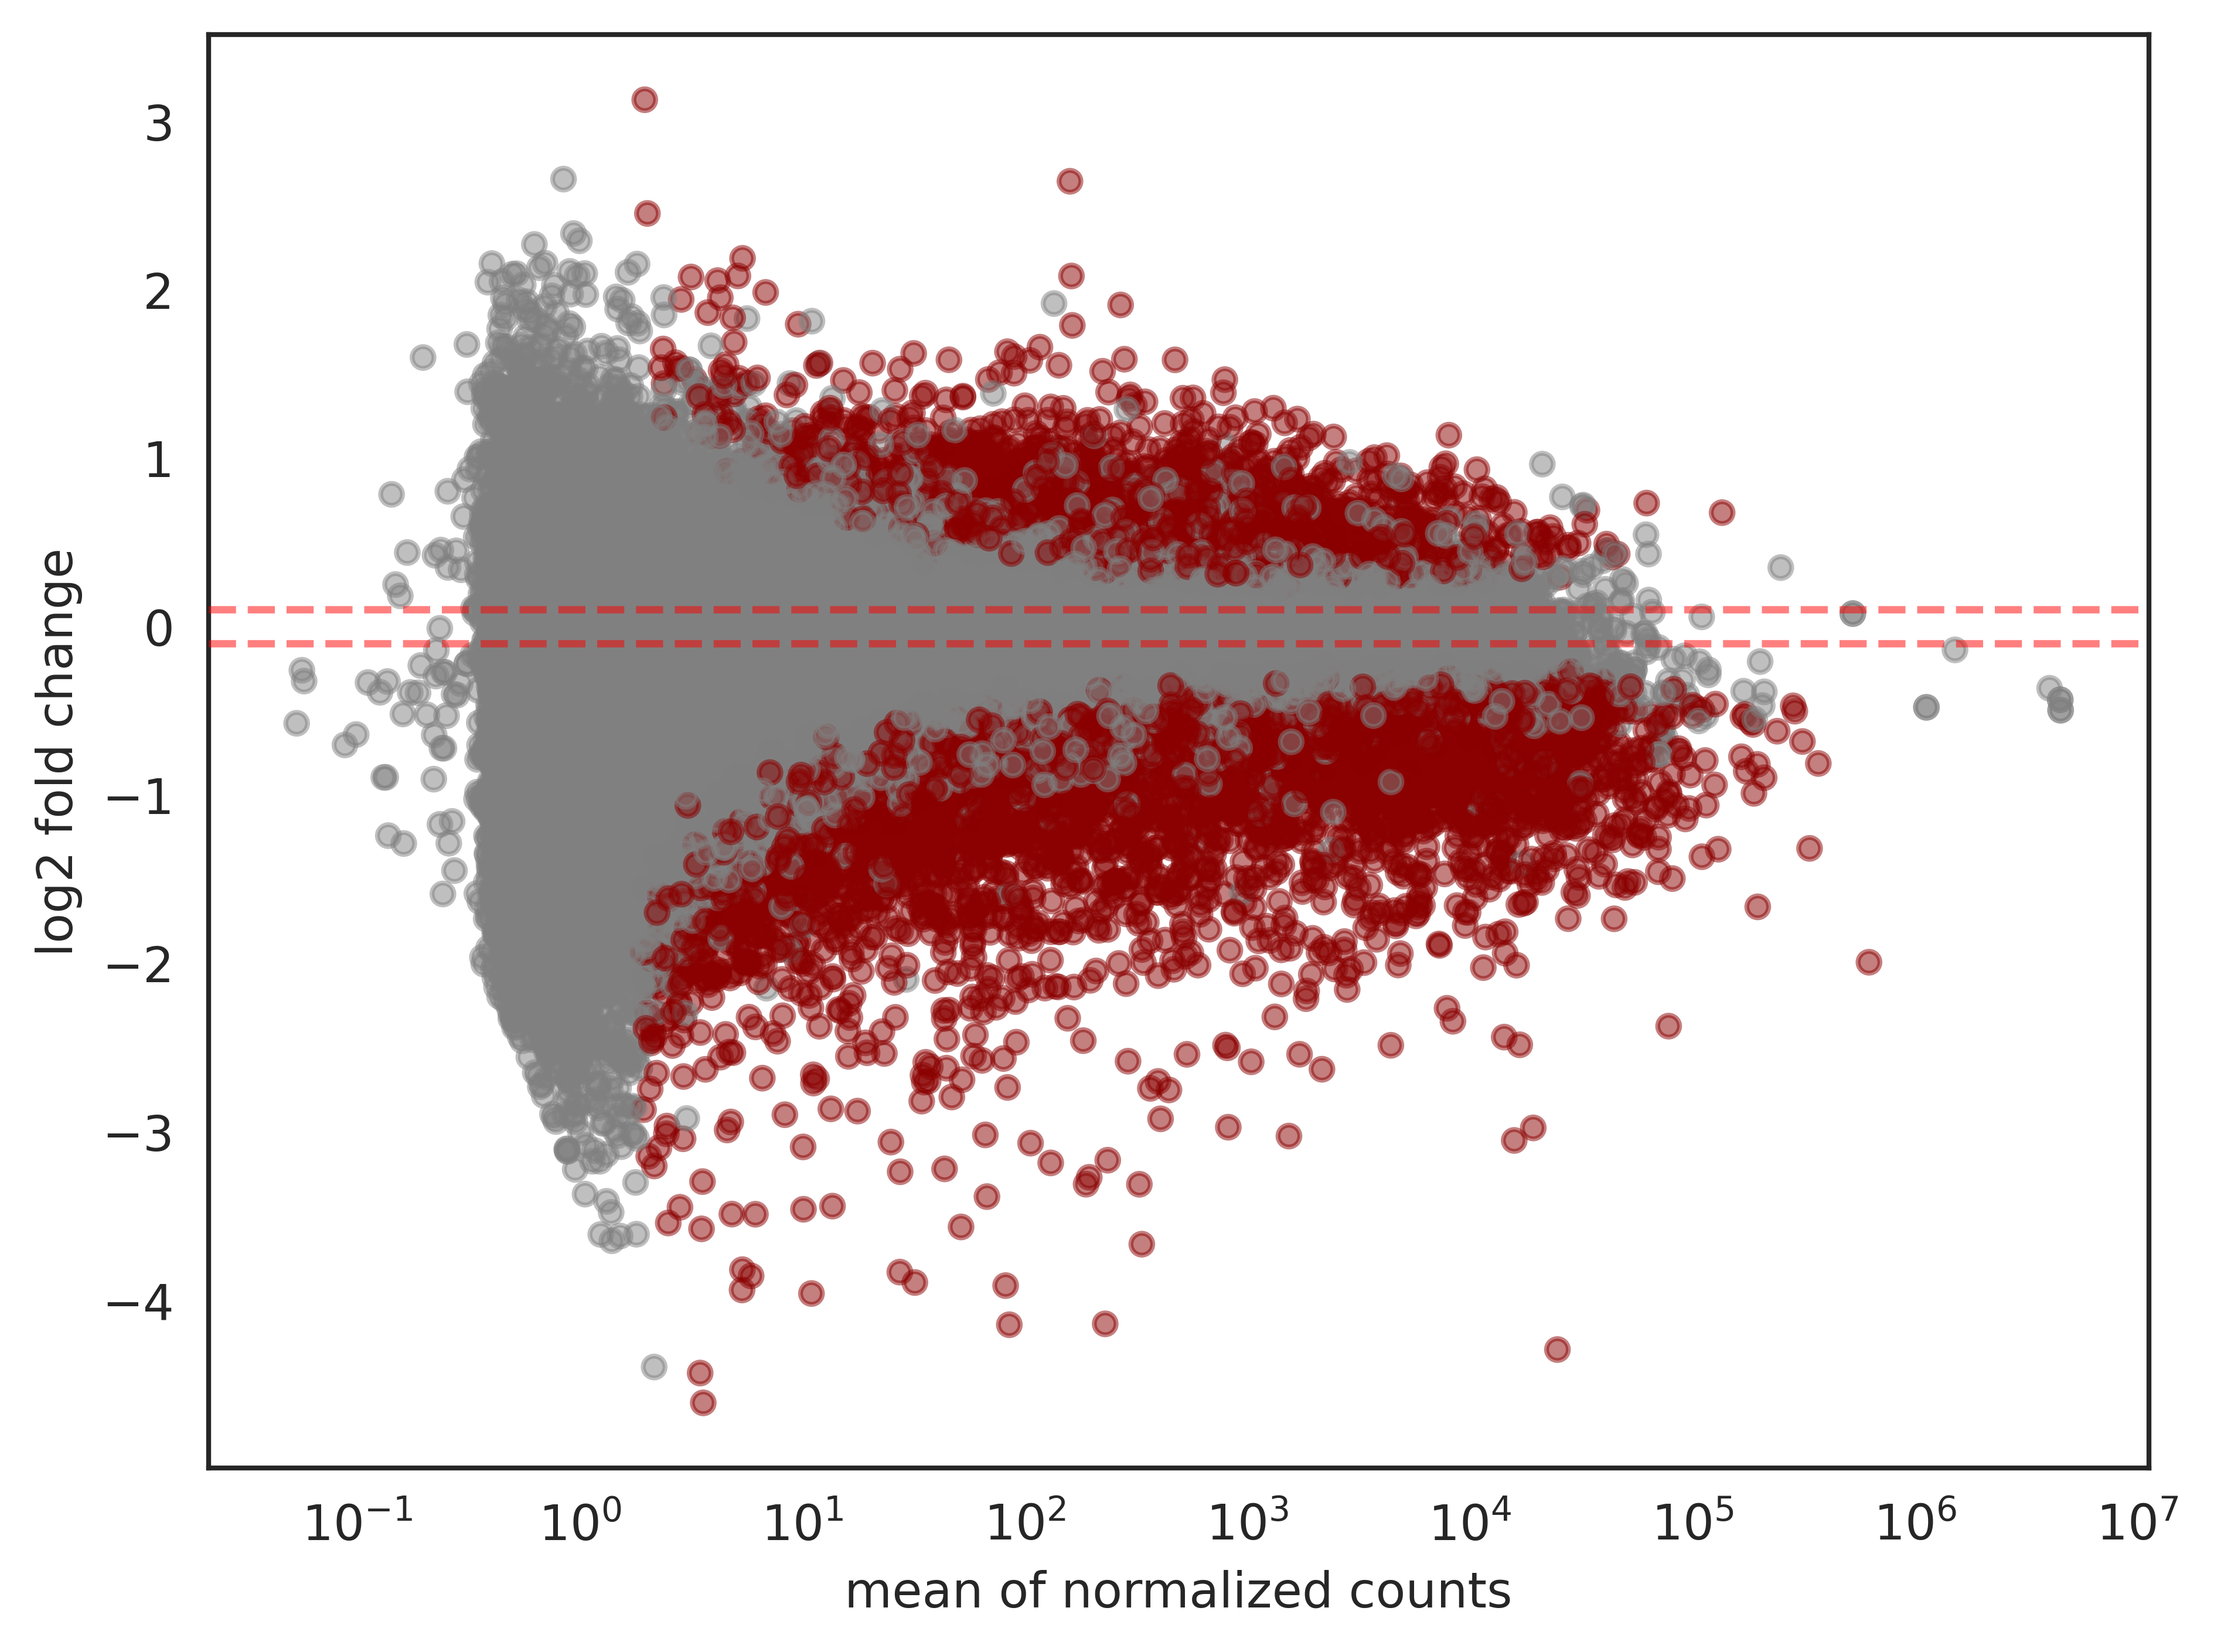

In [51]:
stat_res.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
stat_res.plot_MA(s=20)

In [52]:
stat_res.lfc_shrink(coeff="disease-state_Non-critical_vs_Critical")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: disease-state Non-critical vs Critical
                     baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                             
ENSG00000223972.5    2.396442        0.145308  0.417477  0.892288   
ENSG00000227232.5   66.742697       -0.166425  0.151065 -0.627567   
ENSG00000278267.1   24.248684       -0.078290  0.169463 -0.009016   
ENSG00000238009.6  131.982353       -1.548087  0.271162 -5.791735   
ENSG00000239945.1   11.902295       -2.061267  0.626129 -3.972662   
...                       ...             ...       ...       ...   
ENSG00000198695.2   88.155395       -0.616840  0.333050 -2.297098   
ENSG00000210194.1   33.513697       -0.540152  0.372761 -2.006760   
ENSG00000198727.2  821.586433       -0.488423  0.283126 -2.021726   
ENSG00000210195.2  122.448462       -0.678406  0.389832 -2.346085   
ENSG00000210196.2   79.980552       -0.559321  0.238892 -2.474248   

                  

... done in 20.84 seconds.



In [53]:
if SAVE:
    with open(
        os.path.join(OUTPUT_PATH_DESEQ2, "shrunk_stat_results_detailed_pipe.pkl"), "wb"
    ) as f:
        pkl.dump(stat_res, f)

In [54]:
res = stat_res.results_df


In [55]:
stat_res.results_df.shape

(40588, 6)

### Visualization

In [56]:
from sanbomics.plots import volcano

# Very good toolbox package

In [57]:
# Filter by baseMean at this point to remove lowly expressed genes
# Although debatable, many people use most genes for model building
res = res[res.baseMean >= 10]
#res = res[res.padj <= 0.2]

# around 20K is a fair number of genes, especially if there are several cell types
res.shape

(23381, 6)

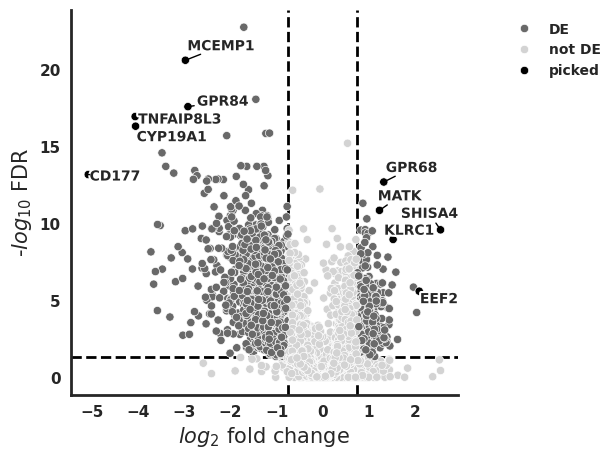

In [58]:
res = pd.merge(res, annotation_genes_name_id, on="gene_id", how="left")
res.rename(columns={"gene_name": "Symbol"}, inplace=True)
volcano(res, symbol="Symbol",log2fc="log2FoldChange")

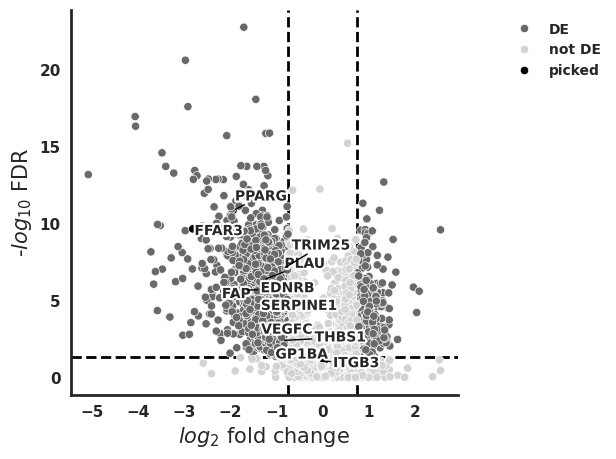

In [59]:
# Some genes from the article. Look very similar (the direction is inversed because I inferred
# Non-critical vs Critical. Non-critical is on the right side, critical - on the left)
volcano(res, symbol="Symbol",log2fc="log2FoldChange",to_label=['PPARG', 'TRIM25', 'PLAU', 'FFAR3', 'SERPINE1', 'VEGFC', 'FAP','ITGB3', 'GP1BA', 'EDNRB', 'THBS1'])

In [60]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 1)]
dds_sigs = dds[:, sigs.index]

In [61]:
print("Number of differentially expressed genes")
sigs.shape

Number of differentially expressed genes


(1111, 8)

In [62]:
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs)

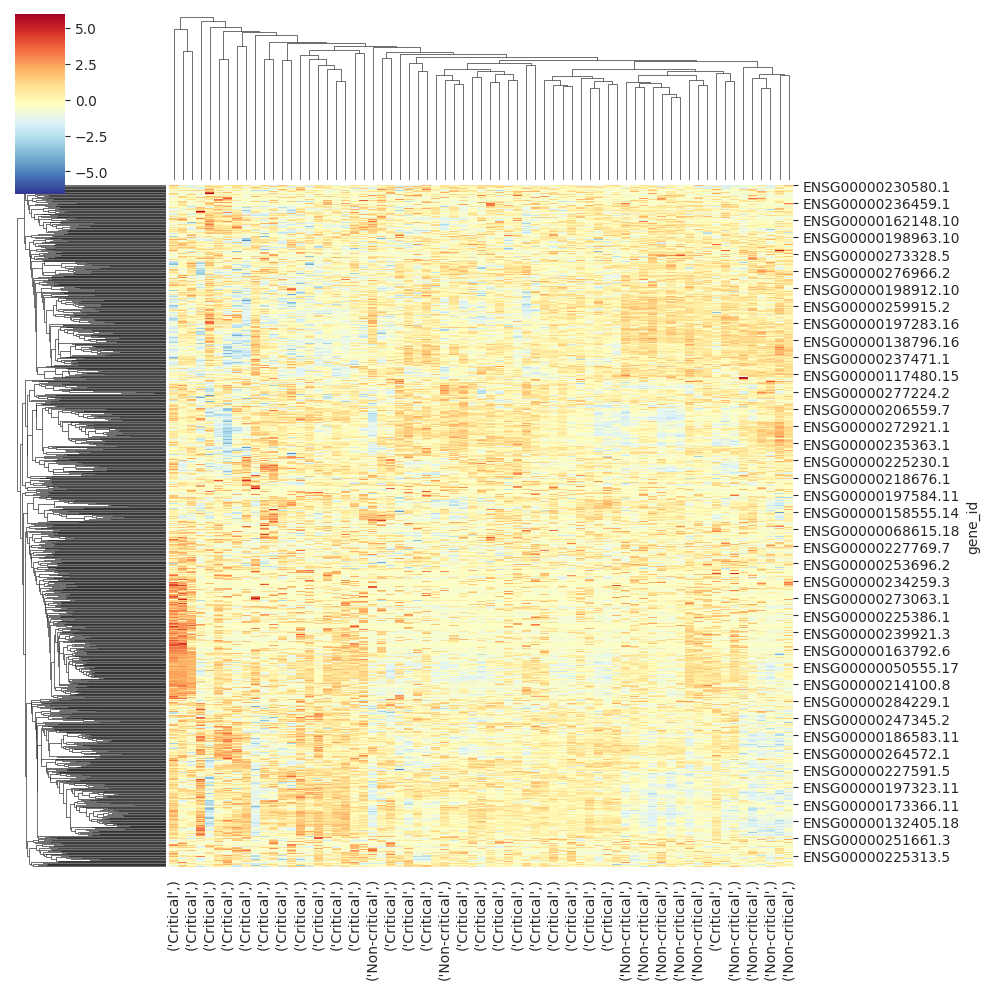

In [63]:
# Doesn't seem, like on PCA earlier, that there are any extremely striking
# differences in this dataset, there are some gene clusters though

sns.clustermap(grapher, z_score=0, cmap = 'RdYlBu_r')

## GSEA

In [64]:
import gseapy as gp
from gseapy import gseaplot

In [65]:
# Ranking for GSEA
ranking =  res[['Symbol', 'stat']].dropna().sort_values('stat', ascending = False)
ranking

Symbol       stat
15584       GPR68   8.229975
21771  AL121845.2   7.800672
19774        MATK   7.643072
17244       SEPT1   7.443536
3897         PASK   7.171649
...           ...        ...
16175   TNFAIP8L3  -9.520479
13816       GPR84  -9.696618
5363      CDC42P6  -9.837057
19878      MCEMP1 -10.448000
6356   AC113404.3 -10.970264

[23381 rows x 2 columns]

In [66]:
# Number of duplicates is quite low
# I could also check them and apply some statistic for collapsing later,
# but kept as is for now

ranking['Symbol'] = list(ranking['Symbol'])
ranking = ranking.drop_duplicates('Symbol')
ranking.set_index("Symbol", inplace=True)
ranking

stat
Symbol               
GPR68        8.229975
AL121845.2   7.800672
MATK         7.643072
SEPT1        7.443536
PASK         7.171649
...               ...
TNFAIP8L3   -9.520479
GPR84       -9.696618
CDC42P6     -9.837057
MCEMP1     -10.448000
AC113404.3 -10.970264

[23227 rows x 1 columns]

In [67]:
ranking.head()

stat
Symbol              
GPR68       8.229975
AL121845.2  7.800672
MATK        7.643072
SEPT1       7.443536
PASK        7.171649

In [86]:
# So the stat duplicates are basically zeros, which means unchanged genes. Shouldn't really affect the analysis
# And one gene with -1.76
ranking['stat'][ranking.stat.duplicated()]

Symbol
CCDC168       0.00000
SNORA69       0.00000
LINC00339     0.00000
AC005832.4    0.00000
CAVIN4        0.00000
               ...   
AC104966.1    0.00000
AC009113.1    0.00000
ACSM3         0.00000
SNAI3         0.00000
RN7SL1       -1.76001
Name: stat, Length: 3759, dtype: float64

In [102]:
ranking[ranking.index == 'RN7SL1']

stat
Symbol         
RN7SL1 -1.76001

In [96]:
# gp.get_library_name()

In [97]:
# The warning comes from the stat value that is repeated. Doesn't seem to affect results
# strongly, because they make sense. But I would look more carefully into this

pre_res = gp.prerank(
    rnk=ranking['stat'],
    gene_sets=['GO_Biological_Process_2023',
               'GO_Cellular_Component_2023',
               'GO_Molecular_Function_2023',
               'KEGG_2021_Human',
               'BioPlanet_2019',
               'WikiPathway_2023_Human',
               'ENCODE_TF_ChIP-seq_2015',
               'BioCarta_2016',
               'MSigDB_Hallmark_2020',
               'Reactome_2022',
               'UK_Biobank_GWAS_v1',
               'GWAS_Catalog_2023'
              ],
    threads=8,
    seed=6,
    permutation_num=100
)

2024-08-13 13:53:22,608 [WARNING] Duplicated values found in preranked stats: 16.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [98]:
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
out_df

Term       fdr        es  \
0     Reactome_2022__Neutrophil Degranulation R-HSA-...  0.000000 -0.653847   
1       BioPlanet_2019__Interferon alpha/beta signaling  0.000000 -0.678553   
2     GO_Cellular_Component_2023__Specific Granule (...  0.000000 -0.706551   
3     Reactome_2022__Interferon Alpha/Beta Signaling...  0.000000 -0.676659   
4           MSigDB_Hallmark_2020__Inflammatory Response  0.000000 -0.606952   
...                                                 ...       ...       ...   
7716               KEGG_2021_Human__Tyrosine metabolism  0.997500 -0.203913   
7717  GO_Biological_Process_2023__Negative Regulatio...  0.997560 -0.185159   
7718  Reactome_2022__Formation Of Tubulin Folding In...  0.998028 -0.192561   
7719  GO_Biological_Process_2023__Gastrulation (GO:0...  0.998421 -0.212679   
7720  GO_Cellular_Component_2023__Anaphase-Promoting...  0.998486 -0.186197   

           nes  
0    -2.529856  
1    -2.218461  
2    -2.538967  
3    -2.193591  
4    -2.251890  
...        ...  
7716 -0.527417  
7717 -0.529151  
7718 -0.517578  
7719 -0.506433  
7720 -0.500829  

[7721 rows x 4 columns]

In [99]:
out_df.sort_values('nes').iloc[2].Term

'Reactome_2022__Neutrophil Degranulation R-HSA-6798695'

In [72]:
#gseaplot(pre_res.ranking,
#         term='GO_Cellular_Component_2023__Secretory Granule Membrane (GO:0030667)',
#         **pre_res.results['GO_Cellular_Component_2023__Secretory Granule Membrane (GO:0030667)'])

In [73]:
pre_res.ranking

gene_name
GPR68          8.229975
AL121845.2     7.800672
MATK           7.643072
SEPT1          7.443536
PASK           7.171649
                ...    
TNFAIP8L3     -9.520479
GPR84         -9.696618
CDC42P6       -9.837057
MCEMP1       -10.448000
AC113404.3   -10.970264
Name: prerank, Length: 23227, dtype: float64

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x14fddb035f50>>
Traceback (most recent call last):
  File "/wrk-vakka/users/nikiarte/rnaseq_analysis/deconvolution/kassandra-env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Traceback (most recent call last):
  File "/wrk-vakka/users/nikiarte/rnaseq_analysis/deconvolution/kassandra-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 426, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/wrk-vakka/appl/easybuild/opt/Miniconda3/23.9.0-0/lib/python3.11/multiprocessing/queues.py", line 108, in get
    if not self._rlock.acquire(block, timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

Traceback (most recent call last):
  File "/wrk-vakka/users/nikiarte/rnaseq_analysis/deconvolution/kassandra-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 426, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/wrk-vakka/appl/easybuild/opt/Miniconda3/23.9.0-0/lib/python3.11/multiprocessing/queues.py

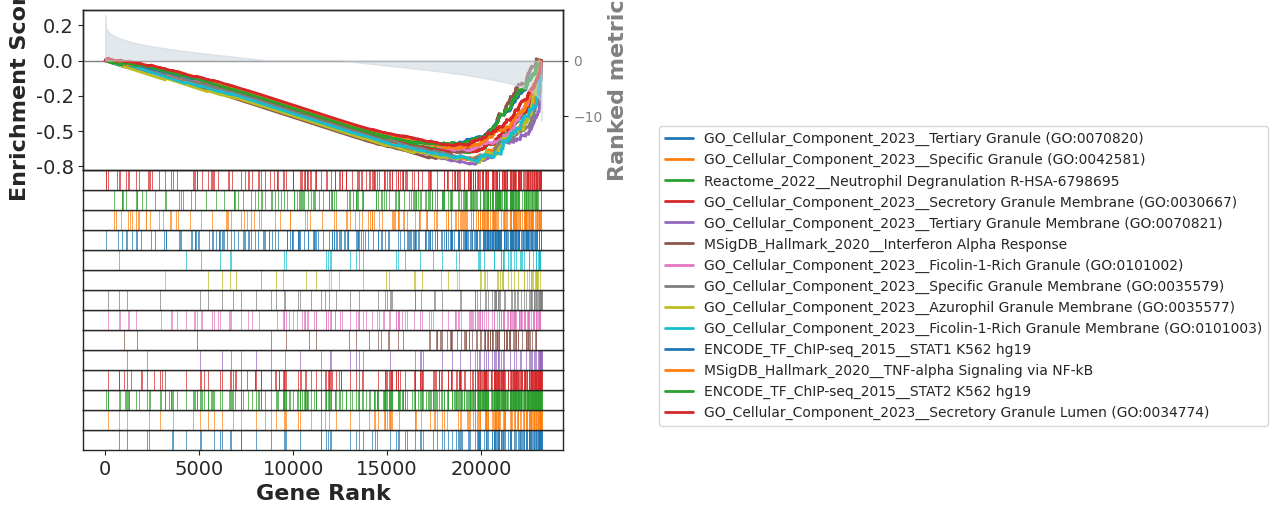

In [74]:
# Interestingly, Neutrophil Degranulation was also a top enriched pathway in the original publication
# Most likely these several inflammation terms are biologically relevant - enriched in critical patients samples

terms = out_df.sort_values('nes').Term[0:14]

axs = pre_res.plot(terms, show_ranking=True, legend_kws={'loc': (1.2, -1.6)}, )


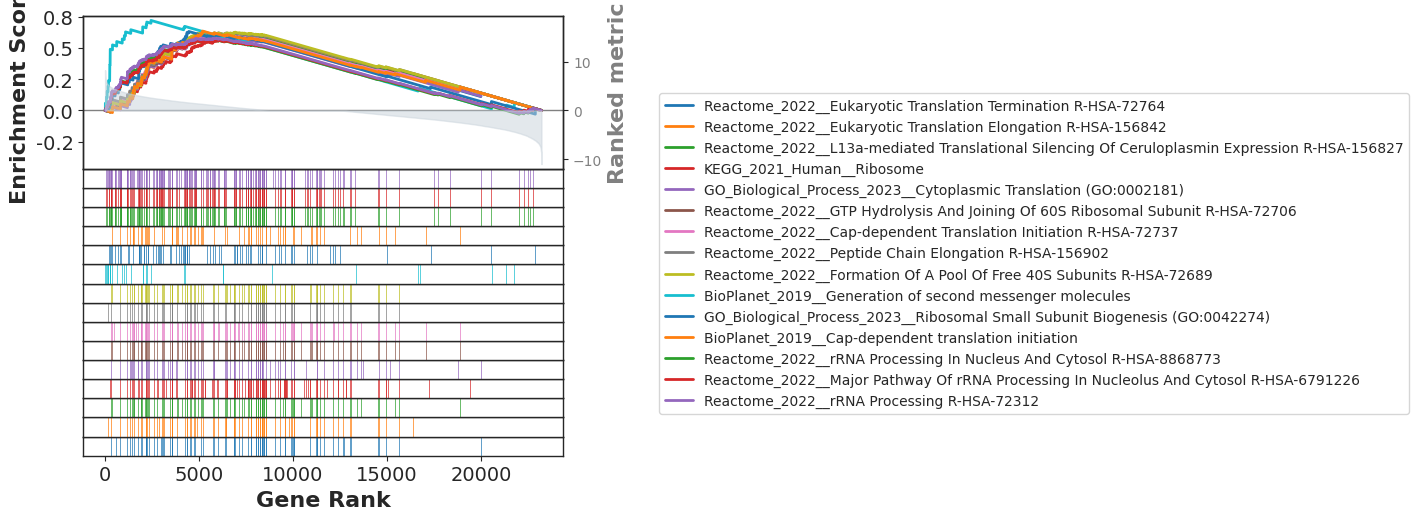

In [75]:
# These cells synthesize proteins and do more anabolic stuff, which is characteeeeeristic of healthier cells
# It's better than granulocyte degranulation - thus makes sense that these are the non-critical enrichments

terms = out_df.sort_values('nes').Term[-15:]
axs = pre_res.plot(terms, show_ranking=True, legend_kws={'loc': (1.2, -1.6)}, )

## WGCNA

In [76]:
import PyWGCNA

In [77]:
RERUN_WGCNA=True

In [78]:
if not RERUN_WGCNA:
    wgcna_file = open('wgcna_output/wgcna_object.pkl', 'rb')
    pyWGCNA_COVID = pkl.load(wgcna_file)
    wgcna_file.close()

In [79]:
if RERUN_WGCNA:
    pyWGCNA_COVID = PyWGCNA.WGCNA(anndata=dds)

In [80]:
pyWGCNA_COVID.geneExpr.to_df().head(5)

gene_id        ENSG00000223972.5  ENSG00000227232.5  ENSG00000278267.1  \
run_accession                                                            
SRR14240730                    0                 29                 25   
SRR14240731                    8                136                 33   
SRR14240732                    0                 66                 35   
SRR14240733                    2                 33                  6   
SRR14240734                    2                 37                 20   

gene_id        ENSG00000238009.6  ENSG00000239945.1  ENSG00000233750.3  \
run_accession                                                            
SRR14240730                   40                  4                  4   
SRR14240731                   39                  4                  5   
SRR14240732                   13                  0                  0   
SRR14240733                   36                  0                  4   
SRR14240734                  205                  3                  2   

gene_id        ENSG00000268903.1  ENSG00000269981.1  ENSG00000239906.1  \
run_accession                                                            
SRR14240730                   19                  3                  9   
SRR14240731                   30                  3                  2   
SRR14240732                   16                  0                  4   
SRR14240733                   48                  2                 12   
SRR14240734                   79                  2                 25   

gene_id        ENSG00000241860.6  ...  ENSG00000198886.2  ENSG00000210176.1  \
run_accession                     ...                                         
SRR14240730                   65  ...                659                 36   
SRR14240731                   96  ...               1424                 11   
SRR14240732                   42  ...                910                 52   
SRR14240733                  134  ...                772                  2   
SRR14240734                  286  ...                358                 12   

gene_id        ENSG00000210184.1  ENSG00000210191.1  ENSG00000198786.2  \
run_accession                                                            
SRR14240730                   36                  7                340   
SRR14240731                   12                 17                480   
SRR14240732                   56                 10                212   
SRR14240733                    2                  7                272   
SRR14240734                   14                  4                166   

gene_id        ENSG00000198695.2  ENSG00000210194.1  ENSG00000198727.2  \
run_accession                                                            
SRR14240730                   32                  7                646   
SRR14240731                  354                127               1446   
SRR14240732                   36                 18                554   
SRR14240733                   10                  2                650   
SRR14240734                   50                 15                250   

gene_id        ENSG00000210195.2  ENSG00000210196.2  
run_accession                                        
SRR14240730                   83                 61  
SRR14240731                   41                 58  
SRR14240732                  141                106  
SRR14240733                   97                100  
SRR14240734                   84                 94  

[5 rows x 40588 columns]

Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..



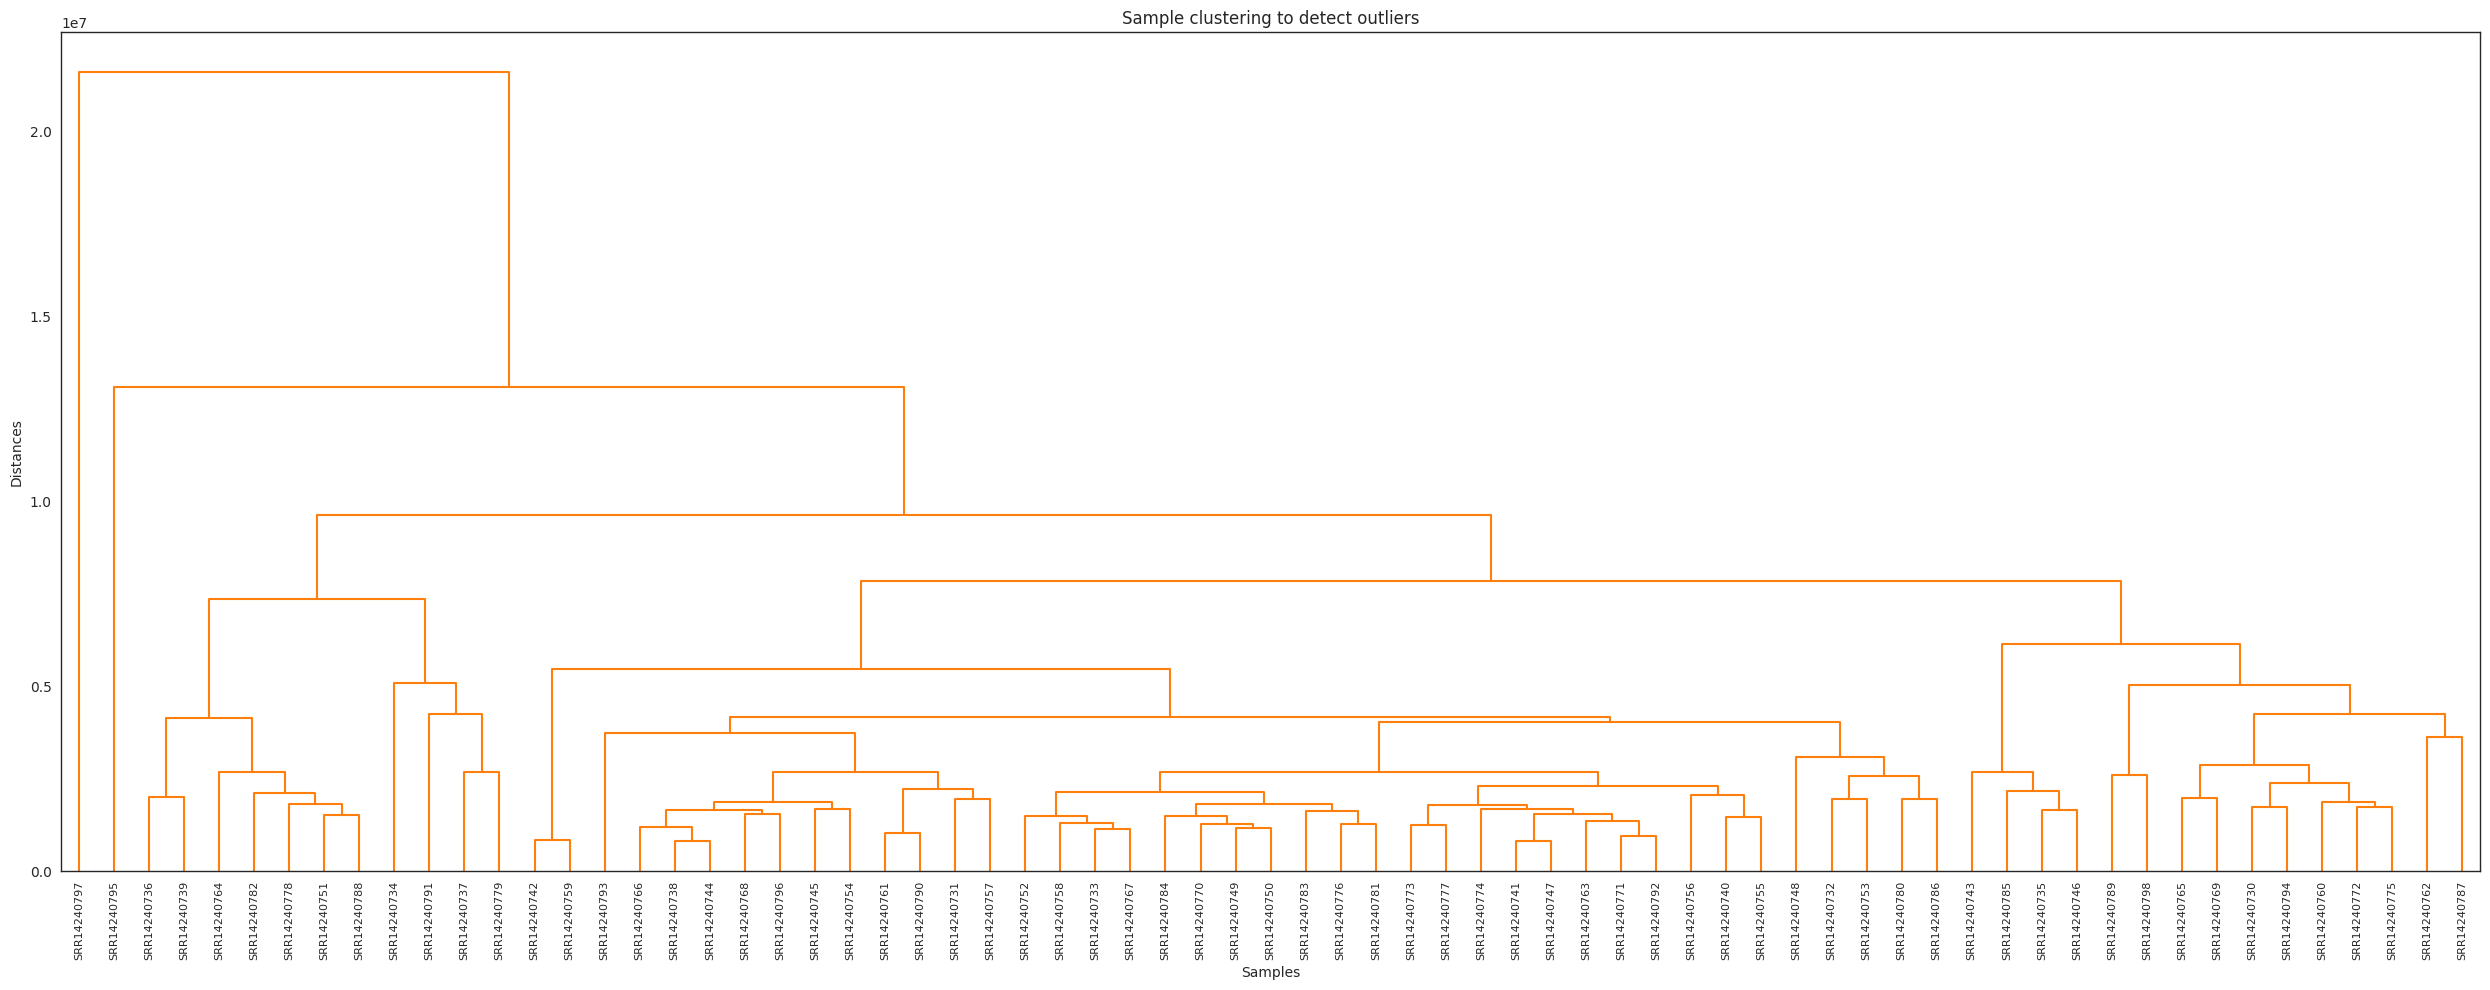

In [81]:
if RERUN_WGCNA:
    pyWGCNA_COVID.preprocess()

In [82]:
if RERUN_WGCNA:
    pyWGCNA_COVID.findModules()

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  1102



KeyboardInterrupt



In [ ]:
SAVE=False

In [ ]:
# A total of 13 modules found
# Linen and Navajowhite modules seem to correlate with disease state. Will check pathways for them

pyWGCNA_COVID.module_trait_relationships_heatmap(metaData=['disease-state'],
                                                 alternative='two-sided')

In [ ]:
# These are some commands to fix non annotating of the dataseet
# by pyWGCNA because of the Ensembl gene versions in gene ids 

pyWGCNA_COVID.geneExpr.var.index = pd.Index(pd.Series(pyWGCNA_COVID.geneExpr.var.index).apply(lambda x: rm_versions(x)))

In [ ]:
pyWGCNA_COVID.datExpr.var.index = pd.Index(pd.Series(pyWGCNA_COVID.datExpr.var.index).apply(lambda x: rm_versions(x)))

In [ ]:
pyWGCNA_COVID.species=SPECIES

In [ ]:
pyWGCNA_COVID.TOM.index = pd.Index(pd.Series(pyWGCNA_COVID.TOM.index).apply(lambda x: rm_versions(x)))

In [ ]:
pyWGCNA_COVID.TOM.columns = pd.Index(pd.Series(pyWGCNA_COVID.TOM.columns).apply(lambda x: rm_versions(x)))

In [ ]:
if RERUN_WGCNA:
    geneList = PyWGCNA.getGeneList(dataset='hsapiens_gene_ensembl',
                               attributes=['ensembl_gene_id', 
                                           'external_gene_name', 
                                           'gene_biotype'],
                               maps=['gene_id', 'gene_name', 'gene_biotype'])




In [ ]:
if RERUN_WGCNA:
    pyWGCNA_COVID.updateGeneInfo(geneList)

In [ ]:
MODULE="linen"
pyWGCNA_COVID.figureType = "png"
gene_set_library = ["GO_Biological_Process_2023",
                    "GO_Cellular_Component_2023",
                    "GO_Molecular_Function_2023"]
pyWGCNA_COVID.functional_enrichment_analysis(type="GO",
                                             moduleName=MODULE,
                                             sets=gene_set_library,
                                             p_value=0.05,
                                             file_name=f'GO_{MODULE}_2023')

In [ ]:
Image(filename=f'figures/GO/GO_{MODULE}_2023.png')

In [ ]:
MODULE="brown"
pyWGCNA_COVID.figureType = "png"
gene_set_library = ["GO_Biological_Process_2023",
                    "GO_Cellular_Component_2023",
                    "GO_Molecular_Function_2023"]
pyWGCNA_COVID.functional_enrichment_analysis(type="GO",
                                             moduleName=MODULE,
                                             sets=gene_set_library,
                                             p_value=0.05,
                                             file_name=f'GO_{MODULE}_2023')

In [ ]:
Image(filename=f'figures/GO/GO_{MODULE}_2023.png')

In [ ]:
MODULE="navajowhite"
pyWGCNA_COVID.figureType = "png"
gene_set_library = ["GO_Biological_Process_2023",
                    "GO_Cellular_Component_2023",
                    "GO_Molecular_Function_2023"]
pyWGCNA_COVID.functional_enrichment_analysis(type="GO",
                                             moduleName=MODULE,
                                             sets=gene_set_library,
                                             p_value=0.05,
                                             file_name=f'GO_{MODULE}_2023')

In [ ]:
Image(filename=f'figures/GO/GO_{MODULE}_2023.png')

In [ ]:
MODULE="linen"
pyWGCNA_COVID.figureType = "png"
gene_set_library = ["KEGG_2021_Human"]
pyWGCNA_COVID.functional_enrichment_analysis(type="KEGG",
                                             moduleName=MODULE,
                                             sets=gene_set_library,
                                             p_value=0.05,
                                             file_name=f'KEGG_{MODULE}_2021')


In [ ]:
MODULE="brown"
pyWGCNA_COVID.figureType = "png"
gene_set_library = ["KEGG_2021_Human"]
pyWGCNA_COVID.functional_enrichment_analysis(type="KEGG",
                                             moduleName=MODULE,
                                             sets=gene_set_library,
                                             p_value=0.05,
                                             file_name=f'KEGG_{MODULE}_2021')

In [ ]:
Image(filename=f'figures/KEGG/KEGG_{MODULE}_2021.png')

In [ ]:
MODULE="navajowhite"
pyWGCNA_COVID.figureType = "png"
gene_set_library = ["KEGG_2021_Human"]
pyWGCNA_COVID.functional_enrichment_analysis(type="KEGG",
                                             moduleName=MODULE,
                                             sets=gene_set_library,
                                             p_value=0.05,
                                             file_name=f'KEGG_{MODULE}_2021')

In [ ]:
Image(filename=f'figures/KEGG/KEGG_{MODULE}_2021.png')

In [ ]:
MODULE="seashell"
pyWGCNA_COVID.figureType = "png"
gene_set_library = ["KEGG_2021_Human"]
pyWGCNA_COVID.functional_enrichment_analysis(type="KEGG",
                                             moduleName=MODULE,
                                             sets=gene_set_library,
                                             p_value=0.05,
                                             file_name=f'KEGG_{MODULE}_2021')

In [ ]:
MODULE="seashell"
pyWGCNA_COVID.figureType = "png"
gene_set_library = ["GO_Biological_Process_2023",
                    "GO_Cellular_Component_2023",
                    "GO_Molecular_Function_2023"]
pyWGCNA_COVID.functional_enrichment_analysis(type="GO",
                                             moduleName=MODULE,
                                             sets=gene_set_library,
                                             p_value=0.05,
                                             file_name=f'GO_{MODULE}_2023')

In [ ]:
# HTML files with networks are built, but an error is still thrown

pyWGCNA_COVID.CoexpressionModulePlot(modules=["linen"], numGenes=10, numConnections=100, minTOM=0)


## HLA-II Typing

### Basic data import

In [351]:
# The 2-digit typing succeeded for most samples, but predicting a 4-digit haplotype is harder
hla_haplotypes = import_seq2hla("snakemake/hla_typing")
hla_haplotypes.head(24)

Locus Allele 1    Confidence        Allele 2  Confidence.1 precision  \
0   DQA1  DQA1*01           NaN  hoz("DQA1*01")           NaN   2digits   
1   DQB1  DQB1*05           NaN  hoz("DQB1*02")           NaN   2digits   
2   DRB1  DRB1*01  4.710501e-02         DRB1*14      0.455553   2digits   
3    DRA   DRA*01           NaN   hoz("DRA*01")           NaN   2digits   
4   DPA1  DPA1*02  7.561377e-02  hoz("DPA1*01")      0.039010   2digits   
5   DPB1  DPB1*04  2.034394e-02         DPB1*10      0.000017   2digits   
6   DQA1       no           NaN              no           NaN   4digits   
7   DQB1       no           NaN      DQB1*05:01           NaN   4digits   
8   DRB1       no           NaN     DRB1*13:02'      0.185563   4digits   
9    DRA       no           NaN              no           NaN   4digits   
10  DPA1       no           NaN              no           NaN   4digits   
11  DPB1       no           NaN              no           NaN   4digits   
12  DQA1  DQA1*02  2.498002e-14         DQA1*05      0.422020   2digits   
13  DQB1  DQB1*02           NaN  hoz("DQB1*02")           NaN   2digits   
14  DRB1  DRB1*07  1.320668e-02         DRB1*03      0.089471   2digits   
15   DRA   DRA*01           NaN   hoz("DRA*01")           NaN   2digits   
16  DPA1  DPA1*01  2.078713e-01  hoz("DPA1*01")           NaN   2digits   
17  DPB1  DPB1*03  1.651071e-02        DPB1*111      0.000000   2digits   
18  DQA1       no           NaN     DQA1*01:01'           NaN   4digits   
19  DQB1       no           NaN      DQB1*03:03      0.329727   4digits   
20  DRB1       no           NaN      DRB1*07:01      0.328579   4digits   
21   DRA       no           NaN              no           NaN   4digits   
22  DPA1       no           NaN              no           NaN   4digits   
23  DPB1       no           NaN              no           NaN   4digits   

      accession  
0   SRR14240794  
1   SRR14240794  
2   SRR14240794  
3   SRR14240794  
4   SRR14240794  
5   SRR14240794  
6   SRR14240794  
7   SRR14240794  
8   SRR14240794  
9   SRR14240794  
10  SRR14240794  
11  SRR14240794  
12  SRR14240748  
13  SRR14240748  
14  SRR14240748  
15  SRR14240748  
16  SRR14240748  
17  SRR14240748  
18  SRR14240748  
19  SRR14240748  
20  SRR14240748  
21  SRR14240748  
22  SRR14240748  
23  SRR14240748

In [352]:
path = os.path.join(OUTPUT_PATH_SEQ2HLA, f'{GSE_ACCESSION}_hla2_haplotypes.csv')
hla_haplotypes.to_csv(path)

In [353]:
metadata_hla = metadata.index.rename("accession", inplace=True)

In [354]:
# Add metadata
hla_haplotypes = pd.merge(hla_haplotypes, metadata, on="accession", how="left")
hla_haplotypes.head()

Locus Allele 1  Confidence        Allele 2  Confidence.1 precision  \
0  DQA1  DQA1*01         NaN  hoz("DQA1*01")           NaN   2digits   
1  DQB1  DQB1*05         NaN  hoz("DQB1*02")           NaN   2digits   
2  DRB1  DRB1*01    0.047105         DRB1*14      0.455553   2digits   
3   DRA   DRA*01         NaN   hoz("DRA*01")           NaN   2digits   
4  DPA1  DPA1*02    0.075614  hoz("DPA1*01")      0.039010   2digits   

     accession disease_state  
0  SRR14240794      Critical  
1  SRR14240794      Critical  
2  SRR14240794      Critical  
3  SRR14240794      Critical  
4  SRR14240794      Critical

In [356]:
# Will only take two-digit haplotypes, because four-digit contain too many NAs

hla_2digits = hla_haplotypes[hla_haplotypes.precision == "2digits"]

In [357]:
hla_2digits.set_index('accession', inplace=True)

### Prepare for statistics        

In [358]:
hla_stats_df = prepare_hla_data_for_stats(hla_2digits)

In [359]:
hla_stats_df

DQA1   DQB1   DRB1    DRA   DPA1    DPB1 disease_state
SRR14240794  01_01  05_02  01_14  01_01  02_01   04_10      Critical
SRR14240748  02_05  02_02  07_03  01_01  01_01  03_111  Non-critical
SRR14240780  01_01  06_02  15_13  01_01  03_02   01_04      Critical
SRR14240768  01_05  06_03  15_11  01_01  01_01   02_03      Critical
SRR14240760  02_01  06_02  07_15  01_01  02_01   04_11      Critical
...            ...    ...    ...    ...    ...     ...           ...
SRR14240791  01_01  06_02  15_13  01_01  01_01   02_01      Critical
SRR14240759  01_05  06_03  13_03  01_01  02_01  01_131      Critical
SRR14240779  02_05  02_03  07_11  01_01  02_01   01_01      Critical
SRR14240785  02_01  03_02  07_14  01_01  01_01   02_04      Critical
SRR14240739  01_01  06_05  14_15  01_01  01_01   15_02  Non-critical

[69 rows x 7 columns]

In [337]:
# DRA seems to be the same for everyone, will not include in the analysis

In [307]:
hla_stats_df.DQB1.unique()

array(['05_02', '02_02', '06_02', '06_03', '05_03', '03_02', '06_05',
       '02_03', '03_06', '03_04'], dtype=object)

In [360]:
# Construct a binary dependent variable
D = hla_stats_df.disease_state.astype('category').cat.codes
D

SRR14240794    0
SRR14240748    1
SRR14240780    0
SRR14240768    0
SRR14240760    0
              ..
SRR14240791    0
SRR14240759    0
SRR14240779    0
SRR14240785    0
SRR14240739    1
Length: 69, dtype: int8

### Statistical analysis

I decided to build separate logistic regression models for each locus. The sample is too small for such a big number of genotype combinations. So I expect the models only to guide us in finding some genotypes in some loci, that seem to lead to interesting critical/non-critical values. But for real variant-association analysis the sample should be at least a hundred times larger. This can also be seen in the non-convergence of models and high p values. For the loci with the highest diversity (DRB1, DPB1) I doubt we can make any conclusions.

I've plotted data for one or two genotypes for each loci with lowest p values.

#### DQA1

In [306]:
smf.logit(formula="D ~ C(DQA1)", data=hla_stats_df).fit().summary()

         Current function value: 0.561163
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      D   No. Observations:                   69
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Aug 2024   Pseudo R-squ.:                  0.1184
Time:                        18:13:02   Log-Likelihood:                -38.720
converged:                      False   LL-Null:                       -43.919
Covariance Type:            nonrobust   LLR p-value:                    0.4063
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1335      0.518      0.258      0.796      -0.881       1.148
C(DQA1)[T.01_05]    -1.3122      0.771     -1.701      0.089      -2.824       0.199
C(DQA1)[T.02_01]    -1.2321      0.967     -1.275      0.202      -3.127       0.663
C(DQA1)[T.02_05]    -0.1335      1.126     -0.119      0.906      -2.340       2.073
C(DQA1)[T.02_06]    25.4361   3.57e+05   7.13e-05      1.000   -6.99e+05    6.99e+05
C(DQA1)[T.03_01]    -1.9253      1.198     -1.607      0.108      -4.273       0.422
C(DQA1)[T.03_02]    -0.5390      1.049     -0.514      0.608      -2.596       1.518
C(DQA1)[T.03_04]   -25.7032   3.57e+05   -7.2e-05      1.000   -6.99e+05    6.99e+05
C(DQA1)[T.03_05]   -20.7474   2.12e+04     -0.001      0.999   -4.15e+04    4.15e+04
C(DQA1)[T.05_01]    -1.0498      0.984     -1.067      0.286      -2.978       0.878
C(DQA1)[T.06_01]    -0.1335      1.506     -0.089      0.929      -3.085       2.818
====================================================================================
"""

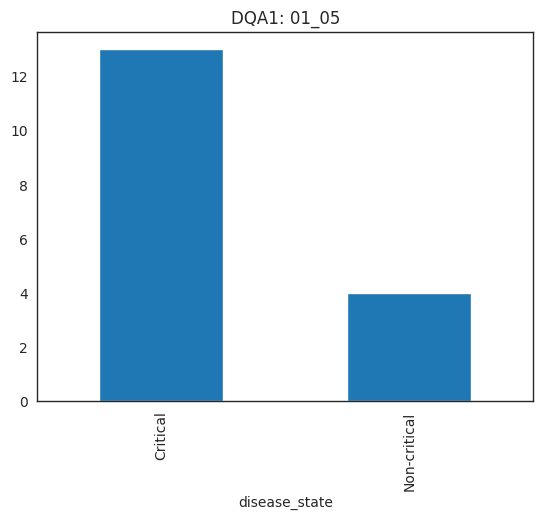

In [368]:
LOCUS = 'DQA1'
GENOTYPE = '01_05'

plot_hla_geno(LOCUS, GENOTYPE, hla_stats_df)

#### DQB1

In [311]:
smf.logit(formula="D ~ C(DQB1)", data=hla_stats_df).fit().summary()

         Current function value: 0.547859
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      D   No. Observations:                   69
Model:                          Logit   Df Residuals:                       59
Method:                           MLE   Df Model:                            9
Date:                Tue, 13 Aug 2024   Pseudo R-squ.:                  0.1393
Time:                        18:26:26   Log-Likelihood:                -37.802
converged:                      False   LL-Null:                       -43.919
Covariance Type:            nonrobust   LLR p-value:                    0.2004
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.571e-11      1.000  -1.57e-11      1.000      -1.960       1.960
C(DQB1)[T.02_03]  1.571e-11      1.291   1.22e-11      1.000      -2.530       2.530
C(DQB1)[T.03_02]    -2.0794      1.458     -1.426      0.154      -4.937       0.778
C(DQB1)[T.03_04]   -25.5697   3.57e+05  -7.17e-05      1.000   -6.99e+05    6.99e+05
C(DQB1)[T.03_06]   -25.5697   3.57e+05  -7.17e-05      1.000   -6.99e+05    6.99e+05
C(DQB1)[T.05_02]    -0.5108      1.238     -0.413      0.680      -2.938       1.916
C(DQB1)[T.05_03]    -0.5596      1.180     -0.474      0.635      -2.873       1.754
C(DQB1)[T.06_02]    -1.9459      1.464     -1.329      0.184      -4.815       0.923
C(DQB1)[T.06_03]    -1.3863      1.275     -1.087      0.277      -3.885       1.112
C(DQB1)[T.06_05]     0.5596      1.180      0.474      0.635      -1.754       2.873
====================================================================================
"""

In [327]:
print(hla_stats_df.DQB1.unique())
print("03_02 correlates with critical status - trend")

['05_02' '02_02' '06_02' '06_03' '05_03' '03_02' '06_05' '02_03' '03_06'
 '03_04']
03_02 correlates with critical status - trend


In [325]:
hla_stats_df[hla_stats_df.DQB1 == '05_02'].groupby('disease_state').count()

DQA1  DQB1  DRB1  DRA  DPA1  DPB1
disease_state                                   
Critical          5     5     5    5     5     5
Non-critical      3     3     3    3     3     3

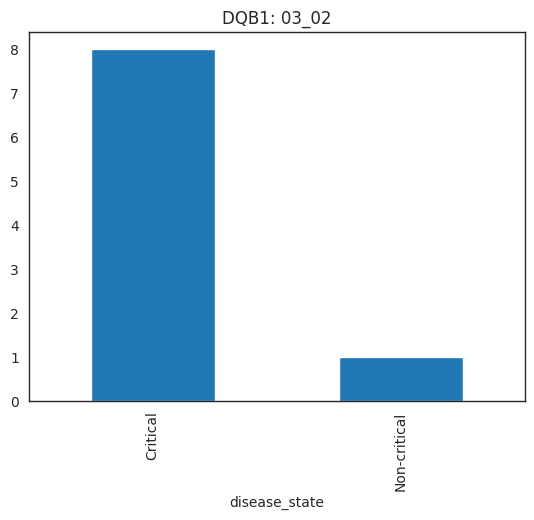

In [371]:
LOCUS = 'DQB1'
GENOTYPE = '03_02'

plot_hla_geno(LOCUS, GENOTYPE, hla_stats_df)

#### DRB1

In [305]:
smf.logit(formula="D ~ C(DRB1)", data=hla_stats_df).fit().summary()

         Current function value: 0.306293
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      D   No. Observations:                   69
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                           41
Date:                Tue, 13 Aug 2024   Pseudo R-squ.:                  0.5188
Time:                        18:12:30   Log-Likelihood:                -21.134
converged:                      False   LL-Null:                       -43.919
Covariance Type:            nonrobust   LLR p-value:                    0.2877
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.0986      1.155     -0.951      0.341      -3.362       1.165
C(DRB1)[T.01_11]  3.558e-09      1.633   2.18e-09      1.000      -3.201       3.201
C(DRB1)[T.01_13]  3.558e-09      1.633   2.18e-09      1.000      -3.201       3.201
C(DRB1)[T.01_14]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.01_15]    26.6683   3.57e+05   7.48e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.03_01]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.03_13]     1.0986      1.826      0.602      0.547      -2.480       4.677
C(DRB1)[T.03_15]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.04_01]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.04_03]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.04_07]   -19.5156   2.12e+04     -0.001      0.999   -4.15e+04    4.15e+04
C(DRB1)[T.04_08]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.04_11]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.04_14]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.04_15]     1.0986      1.826      0.602      0.547      -2.480       4.677
C(DRB1)[T.04_16]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.07_01]    26.6683   3.57e+05   7.48e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.07_03]     1.7918      1.683      1.064      0.287      -1.507       5.091
C(DRB1)[T.07_04]     1.7918      1.683      1.064      0.287      -1.507       5.091
C(DRB1)[T.07_11]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.07_12]    26.6683   3.57e+05   7.48e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.07_13]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.07_14]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.07_15]  3.558e-09      1.633   2.18e-09      1.000      -3.201       3.201
C(DRB1)[T.08_16]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.09_11]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.10_01]    26.6683   3.57e+05   7.48e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.10_11]    26.6683   3.57e+05   7.48e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.11_03]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.11_08]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.12_11]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.12_15]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.13_03]   -24.4711   3.57e+05  -6.86e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.13_11]    26.6683   3.57e+05   7.48e-05      1.000   -6.99e+05    6.99e+05
C(DRB1)[T.13_15]     1.0986      1.826      0.602      0.547      -2.480       4.677
C(DRB1)[T.1

In [377]:
hla_stats_df[hla_stats_df.DRB1 == '15_13'].groupby('disease_state').count()

DQA1  DQB1  DRB1  DRA  DPA1  DPB1
disease_state                                   
Critical          3     3     3    3     3     3

#### DPA1

In [336]:
smf.logit(formula="D ~ C(DPA1)", data=hla_stats_df).fit().summary()

         Current function value: 0.602091
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      D   No. Observations:                   69
Model:                          Logit   Df Residuals:                       64
Method:                           MLE   Df Model:                            4
Date:                Tue, 13 Aug 2024   Pseudo R-squ.:                 0.05408
Time:                        18:45:41   Log-Likelihood:                -41.544
converged:                      False   LL-Null:                       -43.919
Covariance Type:            nonrobust   LLR p-value:                    0.3139
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3677      0.307     -1.199      0.230      -0.969       0.233
C(DPA1)[T.01_02]    -1.0186      1.159     -0.879      0.380      -3.291       1.254
C(DPA1)[T.02_01]    -0.8109      0.649     -1.250      0.211      -2.083       0.461
C(DPA1)[T.03_01]   -20.2462   2.12e+04     -0.001      0.999   -4.15e+04    4.15e+04
C(DPA1)[T.03_02]   -25.2019   3.57e+05  -7.06e-05      1.000   -6.99e+05    6.99e+05
====================================================================================
"""

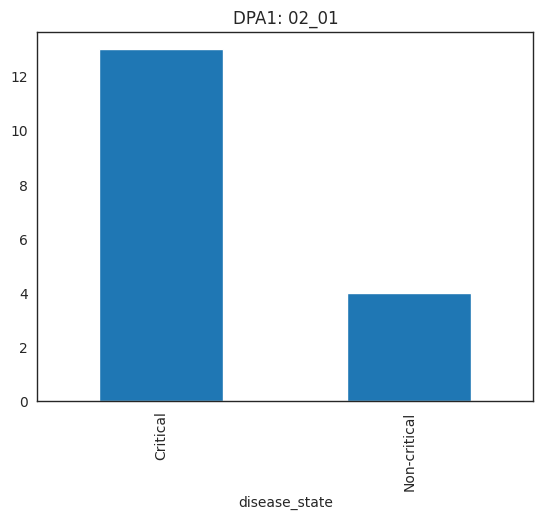

In [372]:
LOCUS = 'DPA1'
GENOTYPE = '02_01'

plot_hla_geno(LOCUS, GENOTYPE, hla_stats_df)


#### DPB1

In [334]:
smf.logit(formula="D ~ C(DPB1)", data=hla_stats_df, method='bfgs').fit().summary()

         Current function value: 0.312280
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      D   No. Observations:                   69
Model:                          Logit   Df Residuals:                       36
Method:                           MLE   Df Model:                           32
Date:                Tue, 13 Aug 2024   Pseudo R-squ.:                  0.5094
Time:                        18:45:16   Log-Likelihood:                -21.547
converged:                      False   LL-Null:                       -43.919
Covariance Type:            nonrobust   LLR p-value:                   0.06665
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -31.5971   7.13e+06  -4.43e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.01_04]      2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.01_131]     2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.02_01]     -8.7569   3.34e+08  -2.62e-08      1.000   -6.55e+08    6.55e+08
C(DPB1)[T.02_03]      2.9982   7.22e+06   4.15e-07      1.000   -1.42e+07    1.42e+07
C(DPB1)[T.02_04]     31.8848   7.13e+06   4.47e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.02_05]     44.4093   7.13e+06   6.23e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.02_10]     44.4093   7.13e+06   6.23e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.02_14]      2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.03_01]      2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.03_02]     31.5971   7.13e+06   4.43e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.03_04]     30.4985   7.13e+06   4.28e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.03_111]    44.4093   7.13e+06   6.23e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.04_01]     31.4429   7.13e+06   4.41e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.04_02]     -0.7464   8.33e+06  -8.96e-08      1.000   -1.63e+07    1.63e+07
C(DPB1)[T.04_05]      2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.04_10]      2.9982   7.22e+06   4.15e-07      1.000   -1.42e+07    1.42e+07
C(DPB1)[T.04_11]      2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.04_17]     31.5971   7.13e+06   4.43e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.04_18]      2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.04_255]     2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.04_307]     2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.04_523]    31.5971   7.13e+06   4.43e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.11_02]      2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.11_04]      2.9982   7.22e+06   4.15e-07      1.000   -1.42e+07    1.42e+07
C(DPB1)[T.131_04]     2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.13_02]     44.4093   7.13e+06   6.23e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.13_04]     44.4093   7.13e+06   6.23e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.15_02]     44.4093   7.13e+06   6.23e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.18_03]     44.4093   7.13e+06   6.23e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.27_05]     44.4093   7.13e+06   6.23e-06      1.000    -1.4e+07     1.4e+07
C(DPB1)[T.39_02]      2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
C(DPB1)[T.39_04]      2.7411   7.37e+06   3.72e-07      1.000   -1.44e+07    1.44e+07
=====================================================================================

Possibly complete quasi-separation: A fraction 0.54 of obs

In [374]:
# smf.logit(formula="D ~ C(DPA1) + C(DPB1) + C(DRB1) + C(DQB1) + C(DQA1)", data=hla_stats_df).fit().summary()

## Deconvolution

### Reading expression data

In [177]:
counts_covid_kallisto = import_kallisto("snakemake/kallisto_abundance")

Reading SRR14240772
Reading SRR14240778
Reading SRR14240796
Reading SRR14240740
Reading SRR14240737
Reading SRR14240785
Reading SRR14240761
Reading SRR14240759
Reading SRR14240753


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
counts_covid_kallisto.head()

### Model training

In [ ]:
cancer_sample_annot = pd.read_csv('data/cancer_samples_annot.tsv.tar.gz', sep='\t', index_col=0)
cancer_expr = pd.read_csv('data/cancer_expr.tsv.tar.gz', sep='\t', index_col=0)
cells_sample_annot = pd.read_csv('data/cells_samples_annot.tsv.tar.gz', sep='\t', index_col=0)
cells_expr = pd.read_csv('data/cells_expr.tsv.tar.gz', sep='\t', index_col=0)


In [ ]:
# Pseudobulk generation
cell_types = CellTypes.load('configs/cell_types.yaml')
mixer = Mixer(cell_types=cell_types,
              cells_expr=cells_expr, cells_annot=cells_sample_annot,
              tumor_expr=cancer_expr, tumor_annot=cancer_sample_annot,
              num_av=3, num_points=30)
expr, values = mixer.generate('Immune_general')
values

In [ ]:
# Model training
mixer = Mixer(cell_types=cell_types,
              cells_expr=cells_expr, cells_annot=cells_sample_annot,
              tumor_expr=cancer_expr, tumor_annot=cancer_sample_annot,
              num_av=3, num_points=30000)

model = DeconvolutionModel(cell_types,
                           boosting_params_first_step='configs/boosting_params/lgb_parameters_first_step.tsv',
                           boosting_params_second_step='configs/boosting_params/lgb_parameters_second_step.tsv')
model.fit(mixer)

### Testing the COVID dataset

In [ ]:
# Testing the COVID dataset
expr = counts_covid_kallisto

expr = tr_to_genes(expr, tr_ids_path='data/blood_model_transcripts.txt')
expr = renorm_expressions(expr, 'data/genes_in_expression.txt')

predictions = model.predict(expr) * 100
print(predictions)

In [ ]:
non_critical = list(metadata[metadata.disease_state == "Non-critical"].index)
critical = list(metadata[metadata.disease_state == "Critical"].index)

In [ ]:
mean_populations = pd.DataFrame(
    {
    "critical_mean": predictions[critical].sum(axis=1)/len(critical),
    #"critical_sd": predictions[critical].std(axis=1),
    "non-critical_mean": predictions[non_critical].sum(axis=1)/len(critical),
    #"non-critical_sd": predictions[non_critical].std(axis=1)
    }
)

In [ ]:
# Interestingly, the predicted cell population proportions
# are relatively similar to those reported in the original article:
# Less CD8 and CD4 T cells in Critical
# More granulocytes and monocytes in Critical - in agreement with higher inflammation

sns.heatmap(
    mean_populations,
    vmax=50,
    center=18,
    cmap='bwr'
)

In [ ]:
granulo = pd.DataFrame(mean_populations.loc["Granulocytes", :])
lympho = pd.DataFrame({"Lymphocytes": mean_populations.loc[["T_cells", "B_cells"], :].sum()})

ratio_df = pd.concat([granulo, lympho], axis=1)
ratio_df["ratio"] = ratio_df["Granulocytes"]/ratio_df["Lymphocytes"]

In [ ]:
ratio_df

## Conclusion

- Raw data from the GSE172114 dataset were processed nominally, the quality is normal, alignment went well with a mean of about 30M reads per sample
- Differential gene expression analysis showed 1111 changed genes with a strict cutoff of log2FC > 1 and adjusted P value of less than 0.05. Among the top transcripts up-regulated in the COVID-19 critical patients are some immunity related genes. Notably CD177 and MCEMP1 expressed on neutrophils, mast cells (MCEMP1), and monocytes.
- Gene set enrichment analysis corroborated these findings and displayed enrichment in inflammatory pathways such as neutrophil degranulation, interferon response, TNF alpha, STAT1 and STAT2 signalling correlating with the critical disease state.
- Weighted Gene Network Correlation analysis suggested 13 regulatory modules of genes correlating with COVID-19 status, although further pathway analysis did not bring any clearly conclusive findings and may need further investigation
- HLA-II genes haplotype analysis was carried out to complement the knowledge about the patients' immune status.
- Deconvolution analysis allowed to study the proportions of cells in peripheral blood of the patients. Congruent with the previous results, critical COVID-19 patients showed lymphopenia amidst strong evaluation of granulocyte level. Interestingly, we found a higher granulocyte/lymphocyte ratio in the critical patients, complementary to recent research showing a correlation of neutrophil to lymphocyte ratio with the disease severity. Neutrophils may make up to 70% of white blood cells, so granulocyte measure may be a good approximation.

To conclude, the patients with the critical form of COVID-19 display more intensive inflammatory processes in peripheral blood, which may be largely attributed to the activity of neutrophils, but also increased presence of monocytes and active inflammatory signaling. Further investigation of HLA-II haplotypes using multiple logistic regression, as well as deeper analysis of WGCNA results may shed light on more details differentiating critical from non-critical COVID-19 patients.